# FRET lines
## Overview
A FRET line is a projection of a parameterized model to a set of single-molecule FRET observables. Such FRET experiment typically jointly determined the fluorescence weighted average lifetime of the donor $\langle \tau \rangle_f$ in the presence of an acceptor and the FRET efficiency, E, for every molecule. Next, a multidimensional frequency histogram of these parameters integrates the detected particles. Often, such histograms are called MFD histograms. The feature image shown to the top of this post displays a set of FRET lines of normally distributed donor-acceptor distances. The red and the blue line ranging from FRET efficiency zero to one corresponds to static FRET lines. Static FRET lines depend on the average donor and acceptor separation distance for a single state. The red line corresponds "broad" and the blue line to "narrow"  donor-acceptor distance distributions. Below I will outline how to calculate a FRET line in ChiSurf.

## Calculation of FRET lines in ChiSurf

A FRET line describes the relationships among the FRET efficiency, E, and the fluorescence weighted average lifetime for the change of a given parameter of a model function. Here, we will make use of the scripting capabilities of ChiSurf to generate a FRET line for a worm-like-chain model, WLC-model. In ChiSurf such FRET lines are calculated the most straightforward way by first creating a new "fit" with the model of interest. Thus, the first step is to load a "dummy" dataset and by creating a new "fit" using the model of interest as shown in the Figure below.

Image1

Next, adjust all parameters of the model. In this tutorial, ChiSurf will exclusively calculate the FRET lines based on the distribution of the fluorescence lifetimes. Hence, nuisance parameters as the time shift, the non-fluorescence background, etc., will not contribute. In the given an example the fraction of FRET inactive molecules "dOnly" is initially 0.2. Change this value to zero. Next, enable the console of ChiSurf for access to the scripting capabilities. On the figure above the console is shown in the lower part of the window.

Finally, paste the script below into the console. This script will iteratively change the 'length' parameter of the WLC-model and gathers the fluorescence weighted average lifetime and the FRET efficiency in the arrays fl and fe.

```python
pa = cs.current_fit.model.parameters_all_dict['length']
model = cs.current_fit.model
fl = list()
fe = list()
scan_range = np.linspace(0.001, 1000, 100)
for v in scan_range:
  pa.value = v
  fe.append(model.transfer_efficiency)
  fl.append(model.fluorescence_averaged_lifetime)
p.plot(fl, fe)
np.savetxt('c://temp//out.txt',np.vstack([scan_range, fl, fe]).T)
```
Finally, the script plots the dependence of these two parameters on the command line as shown below and saves the pair of parameters to the file c:\temp\out.txt. To use this script on your computer, you will have to adjust the filenames.

Image2

## Calculation of FRET lines in Numpy

It is straightforward to calculate a FRET line numerically in Numpy. A FRET line relates the fluorescence weighted average lifetime $latex \langle \tau \rangle_f$ and the FRET efficiency, $latex E$. The fluorescence weighted average lifetime is given by the following integral:

$$ \langle \tau \rangle_f = \int t \cdot f(t) dt / \int f(t) dt$$

Here, $latex f(t)$ is the fluorescence intensity decay. If $latex f(t)$ can be approximated by a sum of exponential decays, the integral $latex \int f(t) dt$ in the bounds from zero to infinity is given by

$$ \int f(t) dt = \sum x_i \tau_i$$

where $latex \tau_i$ are fluorescence lifetimes with the corresponding species fraction $latex x_i$. Similarly, the integral $latex \int t \cdot f(t) dt$ is given by the sum

$$ \int t \cdot f(t) dt = \sum x_i \tau_i^2$$

In the script shown below, these relations are used for an efficient calculation of FRET lines.

As a first step, a distance distribution is calculated. Here, a linear axis "rda" is defined by the function "np.linspace" as a vector. For this vector, a function calculated the distance distribution p(RDA) is calculated. Every element of the distance vector relates to a FRET efficiency and a fluorescence lifetime. The functions "fret2avfret" and "tau2tauf" calculate for the distance distribution p(RDA) the corresponding average fluorescence lifetime and the average FRET efficiency, respectively. Next, a parameter defining the distance distribution, for a static FRET line the mean donor-acceptor distance and for a dynamic FRET line the fraction of a state, is varied. This variation results in a list relating the FRET efficiency to the fluorescence averaged lifetime. Finally, this list is plotted to yield a FRET line.

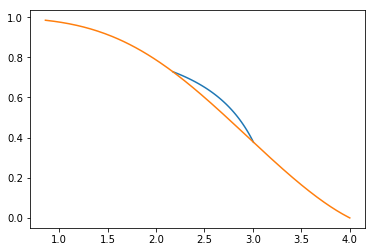

In [4]:
import numpy as np
import pylab as p

# Definition of normal distribution and Gaussian chain distribution
pdf_norm = lambda x, mean, sigma: np.exp(-(x-mean)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)
pdf_mix = lambda x, m1, s1, m2, s2, x1: 0.5 * (x1 * pdf_norm(x, m1, s1) + (1-x1) * pdf_norm(x, m2, s1))

rda2fret = lambda rda, r0: 1./(1+(rda/r0)**6.)
rda2tau = lambda rda, tauD0, r0: (1-rda2fret(rda, r0))*tauD0
tau2taux = lambda x, tau: np.dot(x,tau) / np.sum(x)
fret2avfret = lambda x, fret: np.dot(x, fret) / np.sum(x)
tau2tauf = lambda x, tau: np.dot(x,tau**2) / tau2taux(x,tau) / np.sum(x)

tauD0 = 4.0
r0 = 52.0
sigma = 16.0
rda = np.linspace(0, 250, 250)
fret_efficiency = rda2fret(rda, r0)
tau = rda2tau(rda, tauD0, r0)

# Calculation of a static FRET line
av_fret = list()
tau_f = list()
scan_range = np.linspace(5, 250, 500)
for m_rda in scan_range:
  x = pdf_norm(rda, m_rda, sigma)
  tau_f.append(tau2tauf(x, tau))
  av_fret.append(fret2avfret(x, fret_efficiency))
static_fret = av_fret
static_tau = tau_f

# Calculation of a dynamic FRET line
m1 = 40
m2 = 60
s1 = s2 = sigma
av_fret = list()
tau_f = list()
scan_range = np.linspace(0, 1, 100)
for x1 in scan_range:
  x = pdf_mix(rda, m1, s1, m2, s2, x1)
  tau_f.append(tau2tauf(x, tau))
  av_fret.append(fret2avfret(x, fret_efficiency))
dynamic_fret = av_fret
dynamic_tau = tau_f

p.plot(dynamic_tau, dynamic_fret)
p.plot(static_tau, static_fret)
p.show()

The python script shown above generates two FRET lines, a static and a dynamic FRET line. The figure below displays these FRET lines as blue and green line, respectively.

## Summary

FRET lines can be easily calculated by simple scripts as illustrated above either in separte scripts or in integrated fitting environments as ChiSurf. The advantage of calculating FRET lines in ChiSurf is, that more complex FRET lines can be easily calculated.

Alternatively, FRET lines can be calculated as described in https://github.com/Fluorescence-Tools/FRETlines for normal distributions, the distance distribution between two Normal distributions, and Worm-like chain distribitions.